<a href="https://colab.research.google.com/github/andryll/MGR-IC/blob/main/codes/MGR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Setup


In [22]:
# Importando as Bibliotecas

import numpy as np
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA

In [23]:
# Clonando repo do Git

!git clone https://github.com/andryll/MGR-IC.git

fatal: destination path 'MGR-IC' already exists and is not an empty directory.


###Leitura das Músicas

In [3]:
def readSongs (genre, numSongs, sr=44100):

  # Declarando listas iniciais
  songs = []
  genrelist = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
                'metal', 'pop', 'reggae', 'rock']

  # Se a escolha de gênero não for 'all', substitui a lista pelo gênero escolhido
  if genre != 'all':
    genrelist = [genre]

  #Percorre todos os gêneros da lista
  for g in genrelist:
    #Pega o caminho para a pasta do gênero escolhido
    dir_path = os.path.join('/content/MGR-IC/songs/', g)
    #Lista os arquivos da pasta e os embaralha
    files = os.listdir(dir_path)
    files.sort

    # Até o número de musicas desejado ser alcançado, lê os arquivos de áudio com o librosa
    for i in range(numSongs):
      songs.append(librosa.load(os.path.join(dir_path, files[i]), sr=sr, mono = True))
      # Adciona o gênero como uma variável da tupla
      songs[-1] = songs[-1] + (g,)

  min_len = min(len(song[0]) for song in songs)

  # Garante que as músicas terão o mesmo número de elementos
  min_songs = []
  for song in songs:
      if len(song[0]) > min_len:
        start_trim = int((len(song[0]) - min_len) / 2)
        end_trim = len(song[0]) - start_trim
        trimmed_audio = librosa.util.normalize(song[0][start_trim:end_trim])
        min_songs.append(trimmed_audio)
      else:
        min_songs.append(song[0])

  new_songs = []
  for i in range(len(songs)):
    tupla = (min_songs[i], songs[i][1], songs[i][2])
    new_songs.append(tupla)


  return new_songs

###Extração das Features

In [24]:
# Reduz a dimensionalidade dos dados
def reduceDimension(dataframe, rate=0.99):
  X = dataframe.drop(columns=['Classe']).values.tolist()
  Y = dataframe['Classe'].values.tolist()

  scaler = preprocessing.StandardScaler()
  X_scaled = scaler.fit_transform(X)

  pca = PCA(n_components= rate)
  X_pca = pca.fit_transform(X_scaled)

  df = pd.concat([pd.DataFrame(X_pca), pd.DataFrame({'Classe': Y})], axis=1)

  return df

In [25]:
def featureExtraction (songs, feature, sr=44100, frame=512):

  featurelist = []

  for i in songs:

    match feature:
      case 'zcr':
        zcr = librosa.feature.zero_crossing_rate(i[0], frame_length = frame, hop_length = round(frame/2), center = True)
        aux = pd.DataFrame(zcr[0]).transpose()

      case 'rms':
        rms = librosa.feature.rms(y=i[0], frame_length = frame, hop_length = round(frame/2), center = True)
        aux = pd.DataFrame(rms[0]).transpose()

      case 'mfcc':
        mfcc = librosa.feature.mfcc(y=i[0], sr=sr)
        mfcc = (np.array(mfcc).flatten()).tolist()
        aux = pd.DataFrame(mfcc).transpose()

      case 'centroid':
        sctoid = librosa.feature.spectral_centroid(y=i[0], sr=sr, hop_length = round(frame/2), center = True)
        aux = pd.DataFrame(sctoid[0]).transpose()


      case 'rolloff':
        srloff99 = librosa.feature.spectral_rolloff(y=i[0], sr=sr, hop_length = round(frame/2), center = True, roll_percent=0.95)
        srloff1 = librosa.feature.spectral_rolloff(y=i[0], sr=sr, hop_length = round(frame/2), center = True, roll_percent=0.05)
        aux = pd.concat([pd.DataFrame(srloff1), pd.DataFrame(srloff99)], axis=1)

      case 'all':
        zcr = librosa.feature.zero_crossing_rate(i[0], frame_length = frame, hop_length = round(frame/2), center = True)
        zcrdf = pd.DataFrame(zcr[0]).transpose()

        rms = librosa.feature.rms(y=i[0], frame_length = frame, hop_length = round(frame/2), center = True)
        rmsdf = pd.DataFrame(rms[0]).transpose()

        mfcc = librosa.feature.mfcc(y=i[0], sr=sr)
        mfcc = (np.array(mfcc).flatten()).tolist()
        mfccdf = pd.DataFrame(mfcc).transpose()

        sctoid = librosa.feature.spectral_centroid(y=i[0], sr=sr, hop_length = round(frame/2), center = True)
        sctoiddf = pd.DataFrame(sctoid[0]).transpose()

        srloff99 = librosa.feature.spectral_rolloff(y=i[0], sr=sr, hop_length = round(frame/2), center = True, roll_percent=0.95)
        srloff1 = librosa.feature.spectral_rolloff(y=i[0], sr=sr, hop_length = round(frame/2), center = True, roll_percent=0.05)
        srloff99df = pd.DataFrame(srloff99)
        srloff1df = pd.DataFrame(srloff1)

        aux = pd.concat([zcrdf, rmsdf, mfccdf, sctoiddf, srloff1df, srloff99df], axis=1)

      case _:
        print('Feature Inválida')

    aux['Classe'] = i[2]
    featurelist.append(aux)

  df = pd.concat(featurelist, axis=0)
  df = reduceDimension(df, 0.99)

  return df

### Algoritmos de ML


In [26]:
def KFoldCrossValidation(dataframe, n_splits, seed):

    target = 'Classe'
    X_columns = dataframe.columns[dataframe.columns != target]
    X = dataframe[X_columns]
    Y = dataframe[target]

    skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state = seed)

    X_train_list = []
    X_test_list = []
    Y_train_list = []
    Y_test_list = []

    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        # Armazenar os vetores de treino e teste nas listas
        X_train_list.append(X_train.values.tolist())
        X_test_list.append(X_test.values.tolist())
        Y_train_list.append(Y_train.to_list())
        Y_test_list.append(Y_test.to_list())

    return X_train_list, X_test_list, Y_train_list, Y_test_list

In [27]:
def elbowKNN(dflist, n_neigh, seed):


  scorelist = []

  for df in dflist:
    neigh = neighbors.KNeighborsClassifier(n_neighbors= n_neigh)

    X_train, X_test, Y_train, Y_test = KFoldCrossValidation(df, n_splits = 10, seed = seed)

    auxlist = []

    for i in range(10):

        neigh.fit(X_train[i], Y_train[i])
        Y_predict = neigh.predict(X_test[i])
        auxlist.append(balanced_accuracy_score(Y_test[i], Y_predict))

    scorelist.append(np.mean(np.array(auxlist), axis = 0))

  return scorelist

In [28]:
def elbowTree(dflist, seed):

  scorelist = []

  for df in dflist:
    clf = tree.DecisionTreeClassifier(random_state = seed)

    X_train, X_test, Y_train, Y_test = KFoldCrossValidation(df, n_splits = 10, seed = seed)

    auxlist = []

    for i in range(10):

        clf.fit(X_train[i], Y_train[i])
        Y_predict = clf.predict(X_test[i])
        auxlist.append(balanced_accuracy_score(Y_test[i], Y_predict))

    scorelist.append(np.mean(np.array(auxlist), axis = 0))

  return scorelist

In [29]:
def elbowRF(dflist, seed):

  scorelist = []

  for df in dflist:
    rf = ensemble.RandomForestClassifier(random_state = seed)

    X_train, X_test, Y_train, Y_test = KFoldCrossValidation(df, n_splits = 10, seed = seed)

    auxlist = []

    for i in range(10):

        rf.fit(X_train[i], Y_train[i])
        Y_predict = rf.predict(X_test[i])
        auxlist.append(balanced_accuracy_score(Y_test[i], Y_predict))

    scorelist.append(np.mean(np.array(auxlist), axis = 0))

  return scorelist

### Testes

In [30]:
# Lê as músicas
songs = readSongs ('all', 50, 44100)

In [31]:
# Extrai as features para os frame lenghts desejados
frame_lenghts = [256, 512, 1024, 2048, 4096, 8192]

dflist = []
for f in frame_lenghts:
  dflist.append(featureExtraction(songs, 'all', 44100, frame=f))

In [32]:
# Executa os algoritmos com as features desejadas e salva os valores de score nas listas

knnscores3 = []
knnscores5 = []
knnscores7 = []
dtscores = []
rfscores = []
seeds = [14, 42, 60, 87, 113, 156, 211, 456, 917, 1001]

for seed in seeds:
  knnscores3.append(elbowKNN(dflist, n_neigh = 3, seed = seed))
  knnscores5.append(elbowKNN(dflist, n_neigh = 5, seed = seed))
  knnscores7.append(elbowKNN(dflist, n_neigh = 7, seed = seed))

  dtscores.append(elbowTree(dflist, seed = seed))
  rfscores.append(elbowRF(dflist, seed = seed))

### Plot dos Diagramas

In [33]:
# Coloca as listas de score em uma outra lista a cria listas com as médias e os sds.

scoreslist = []
scoresmeans = []
scoressds = []

scoreslist.append(np.array(knnscores3))
scoreslist.append(np.array(knnscores5))
scoreslist.append(np.array(knnscores7))
scoreslist.append(np.array(dtscores))
scoreslist.append(np.array(rfscores))

# KNN3 = 0 / KNN5 = 1 / KNN7 = 2 / DT = 3 / RF = 4

for score in scoreslist:
  scoresmeans.append(np.mean(score, axis=0))
  scoressds.append(np.std(score, axis=0))

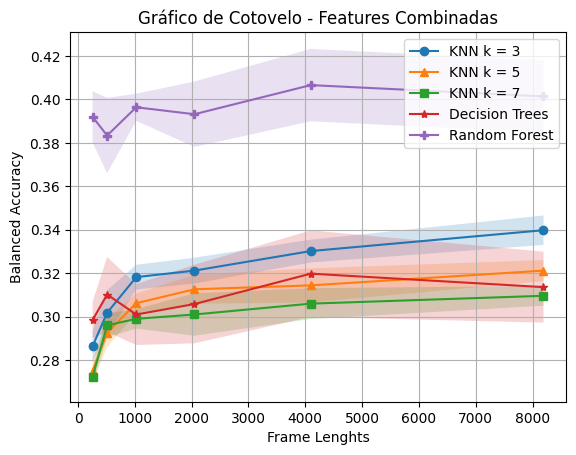

In [34]:
#  Plota o gráfico com as médias das seeds e os desvios padrão

labels = ['KNN k = 3', 'KNN k = 5', 'KNN k = 7', 'Decision Trees', 'Random Forest']
markers = ['o', '^', 's', '*', 'P']

for i in range(len(scoresmeans)):
  plt.plot(frame_lenghts, scoresmeans[i], label = labels[i], marker = markers[i])
  plt.fill_between(frame_lenghts, scoresmeans[i] + scoressds[i], scoresmeans[i] - scoressds[i], alpha = 0.2)

plt.legend()
plt.grid()
plt.ylabel('Balanced Accuracy')
plt.xlabel('Frame Lenghts')
plt.title('Gráfico de Cotovelo - Features Combinadas')

# Nome do arquivo pra salvar
plt.savefig('all.pdf')
plt.show()

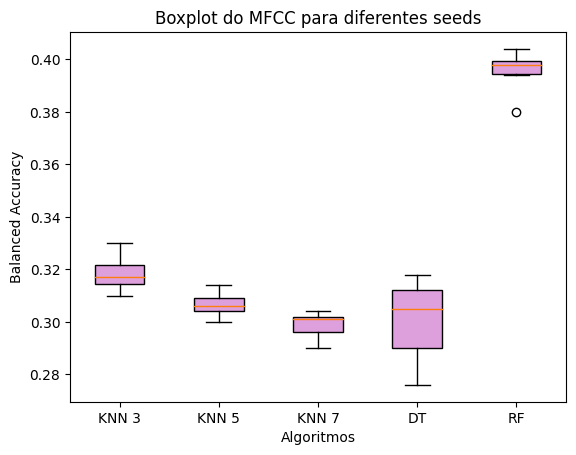

In [17]:
#Plotando o boxplot

boxplot = []
boxplot.append((np.array(knnscores3).flatten()).tolist())
boxplot.append((np.array(knnscores5).flatten()).tolist())
boxplot.append((np.array(knnscores7).flatten()).tolist())
boxplot.append((np.array(dtscores).flatten()).tolist())
boxplot.append((np.array(rfscores).flatten()).tolist())

algs = ['KNN 3', 'KNN 5', 'KNN 7', 'DT', 'RF']
cores= ['red','green','purple','orange','blue']
box = plt.boxplot(boxplot, labels=algs, patch_artist=True,
            boxprops=dict(facecolor='plum', color='black'))

plt.title('Boxplot do MFCC para diferentes seeds')
plt.xlabel('Algoritmos')
plt.ylabel('Balanced Accuracy')

plt.savefig('mfcc.pdf')
plt.show()

In [21]:
# Plot alternativo com gráfico de barras

# algs = ['KNN 3', 'KNN 5', 'KNN 7', 'DT', 'RF']

# def addlabels(x,y):
#     for i in range(len(x)):
#         plt.text(i+0.02, y[i] + 0.005, round(y[i], 3))

# plt.bar(algs, sm, color=['plum','lightblue','palegreen','khaki','lightcoral'])
# plt.errorbar(algs,sm,sd,fmt='.',color='Black', elinewidth=2,capthick=8,errorevery=1, alpha=0.8, ms=2, capsize = 1.5)
# plt.ylabel('Balanced Accuracy')
# plt.xlabel('Algoritmos')

# addlabels(algs, sm)

# plt.title('MFCC')
# plt.savefig('mfcc.pdf')
# plt.show()